In [22]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib

from scipy import signal
from scipy.signal import find_peaks
from scipy.integrate import cumtrapz

from datetime import datetime

In [23]:
# サンプリングレート(0.015秒に1回)
sampling_rate = 66

filter_num = sampling_rate * 1

In [24]:
class Data:
    def __init__(self, folder_name):
        self.folder_name = 'data/' + folder_name
        self.path = folder_name
        self.file_names = os.listdir(self.folder_name)

        self.start_time = None
        self.end_time = None

        self.df = pd.DataFrame()

        # acceleration.csvがない場合は作成する
        if 'acceleration.csv' not in self.file_names:
            self.make_acceleration()
            self.file_names = os.listdir(self.folder_name)
        
        # 'all.csv'がある場合は削除する
        if 'all.csv' in self.file_names:
            self.file_names.remove('all.csv')
        
        for file_name in self.file_names:
            df_tmp = pd.read_csv(os.path.join(self.folder_name, file_name))
            file_type = file_name.replace('.csv', '')

            # 列名を変更してファイル名を追加
            df_tmp = df_tmp.rename(columns={'x': file_type + '_x', 'y': file_type + '_y', 'z': file_type + '_z'})
            
            # 'rotate.csv' に 'w' 列がある場合は削除
            if 'w' in df_tmp.columns and file_name == 'rotate.csv':
                df_tmp = df_tmp.drop(['w'], axis=1)

            if type(df_tmp['time'][0]) == int:
                # 'time'列の変換を実行
                df_tmp['time'] = df_tmp['time'] / 1000
                df_tmp['time'] = pd.to_datetime(df_tmp['time'], unit='s')

            # df_tmpをdfに追記する,既にある列名は追記しない
            self.df = pd.concat([self.df, df_tmp], axis=1, sort=False)

            # 呼び出したファイルに上書き保存する
            df_tmp.to_csv(os.path.join(self.folder_name, file_name), index=False)

        # 1行目のtime列以外のtime列を削除する
        self.df = self.df.iloc[:, [0] + [i for i in range(1, len(self.df.columns)) if not self.df.columns[i].startswith('time')]]
        self.df['time'] =pd.to_datetime(self.df['time']/1000,unit='s')

        # csvファイルを出力する
        self.df.to_csv(os.path.join(self.folder_name, 'all.csv'), index=False)

    def make_acceleration(self):
        df_tmp = pd.read_csv(os.path.join(self.folder_name, 'velocity.csv'))
        df_acc = df_tmp
        # df_tmpからx,y,z列を削除する
        df_acc = df_acc.drop(['x', 'y', 'z'], axis=1)
        df_acc['x'] = df_tmp['x'].cumsum()
        df_acc['y'] = df_tmp['y'].cumsum()
        df_acc['z'] = df_tmp['z'].cumsum()
        df_acc.to_csv(os.path.join(self.folder_name, 'acceleration.csv'), index=False)
        df_acc = df_acc.drop(['time'],axis =1 )
        df_acc['acceleration_x'] = df_acc['x']
        df_acc['acceleration_y'] = df_acc['y']
        df_acc['acceleration_z'] = df_acc['z']
        df_acc = df_acc.drop(['x', 'y', 'z'], axis=1)
        self.df = pd.concat([self.df, df_acc], axis=1, sort=False)
        return self

    def low_filter(self, column_type, n):
        if column_type == 'all':
            for column in self.file_names:
                column = column.replace('.csv', '')
                if column == 'all':
                    pass
                self.low_filter(column, n)
        else:
            column = column_type + '_x'
            out_column = column_type + '_low_x'
            self.df[out_column] = self.df[column].rolling(n).mean()
            column = column_type + '_y'
            out_column = column_type + '_low_y'
            self.df[out_column] = self.df[column].rolling(n).mean()
            column = column_type + '_z'
            out_column = column_type + '_low_z'
            self.df[out_column] = self.df[column].rolling(n).mean()
        return self

    def high_filter(self, column_type, n):
        if column_type == 'all':
            for column in self.file_names:
                column = column.replace('.csv', '')
                if column == 'all':
                    pass
                self.high_filter(column, n)
        else:
            column = column_type + '_x'
            out_column = column_type + '_high_x'
            self.df[out_column] = self.df[column] -  self.df[column].rolling(n,center = False).mean()
            column = column_type + '_y'
            out_column = column_type + '_high_y'
            self.df[out_column] = self.df[column] -  self.df[column].rolling(n,center = False).mean()
            column = column_type + '_z'
            out_column = column_type + '_high_z'
            self.df[out_column] = self.df[column] -  self.df[column].rolling(n,center = False).mean()
        return self
    
    def diff(self, column_type):
        if column_type == 'all':
            for column in self.file_names:
                column = column.replace('.csv', '')
                if column == 'all':
                    pass
                self.diff(column)
        else:
            column = column_type + '_x'
            out_column = column_type + '_diff_x'
            self.df[out_column] = self.df[column].diff()
            column = column_type + '_y'
            out_column = column_type + '_diff_y'
            self.df[out_column] = self.df[column].diff()
            column = column_type + '_z'
            out_column = column_type + '_diff_z'
            self.df[out_column] = self.df[column].diff()
        return self

    def plot(self, column_type ,option, axis):
        self.i = 0
        self.fig = plt.figure(figsize=(15, 25))
        
        if column_type == 'all':
            # 'all.csv'がある場合は削除する
            for column in self.file_names:
                column = column.replace('.csv', '')
                if column == 'all':
                    continue
                self.ax(column, option,axis)
                self.i += 1
        else:
            column_type = column_type.replace('.csv', '')
            self.ax(column_type, option,axis)
        plt.show()

    def ax(self, column_type ,option,axis):
        self.low_filter(column_type, filter_num)
        ax = self.fig.add_subplot(5, 1, self.i+1)
        if option == "axvspan":
            self.axvspan(column_type)
        if option == "diff":
            column_type = column_type + '_diff'
        if option == "high":
            column_type = column_type + '_high'
        if option == "low":
            column_type = column_type + '_low'  
        match axis:
            case 'x':
                ax.plot(self.df['time'], self.df[column_type + '_x'], label = column_type + '_x')
            case 'y':
                ax.plot(self.df['time'], self.df[column_type + '_y'], label = column_type + '_y')
            case 'z':
                ax.plot(self.df['time'], self.df[column_type + '_z'], label = column_type + '_z')
            case _:
                ax.plot(self.df['time'], self.df[column_type + '_x'], label = column_type + '_x')
                ax.plot(self.df['time'], self.df[column_type + '_y'], label = column_type + '_y')
                ax.plot(self.df['time'], self.df[column_type + '_z'], label = column_type + '_z')
        ax.legend()
        # タイトル
        ax.set_title(column_type)
        ax.set_xlabel('time')
        ax.set_ylabel(column_type)
        ax.grid()

    def axvspan(self,column_type):
        ax.axvspan(self.start_time, self.end_time, color='red', alpha=0.5)

    def split_time(self, start_time, end_time):
        self.df = self.df[(self.df['time'] >= start_time) & (self.df['time'] <= end_time)]
        return self

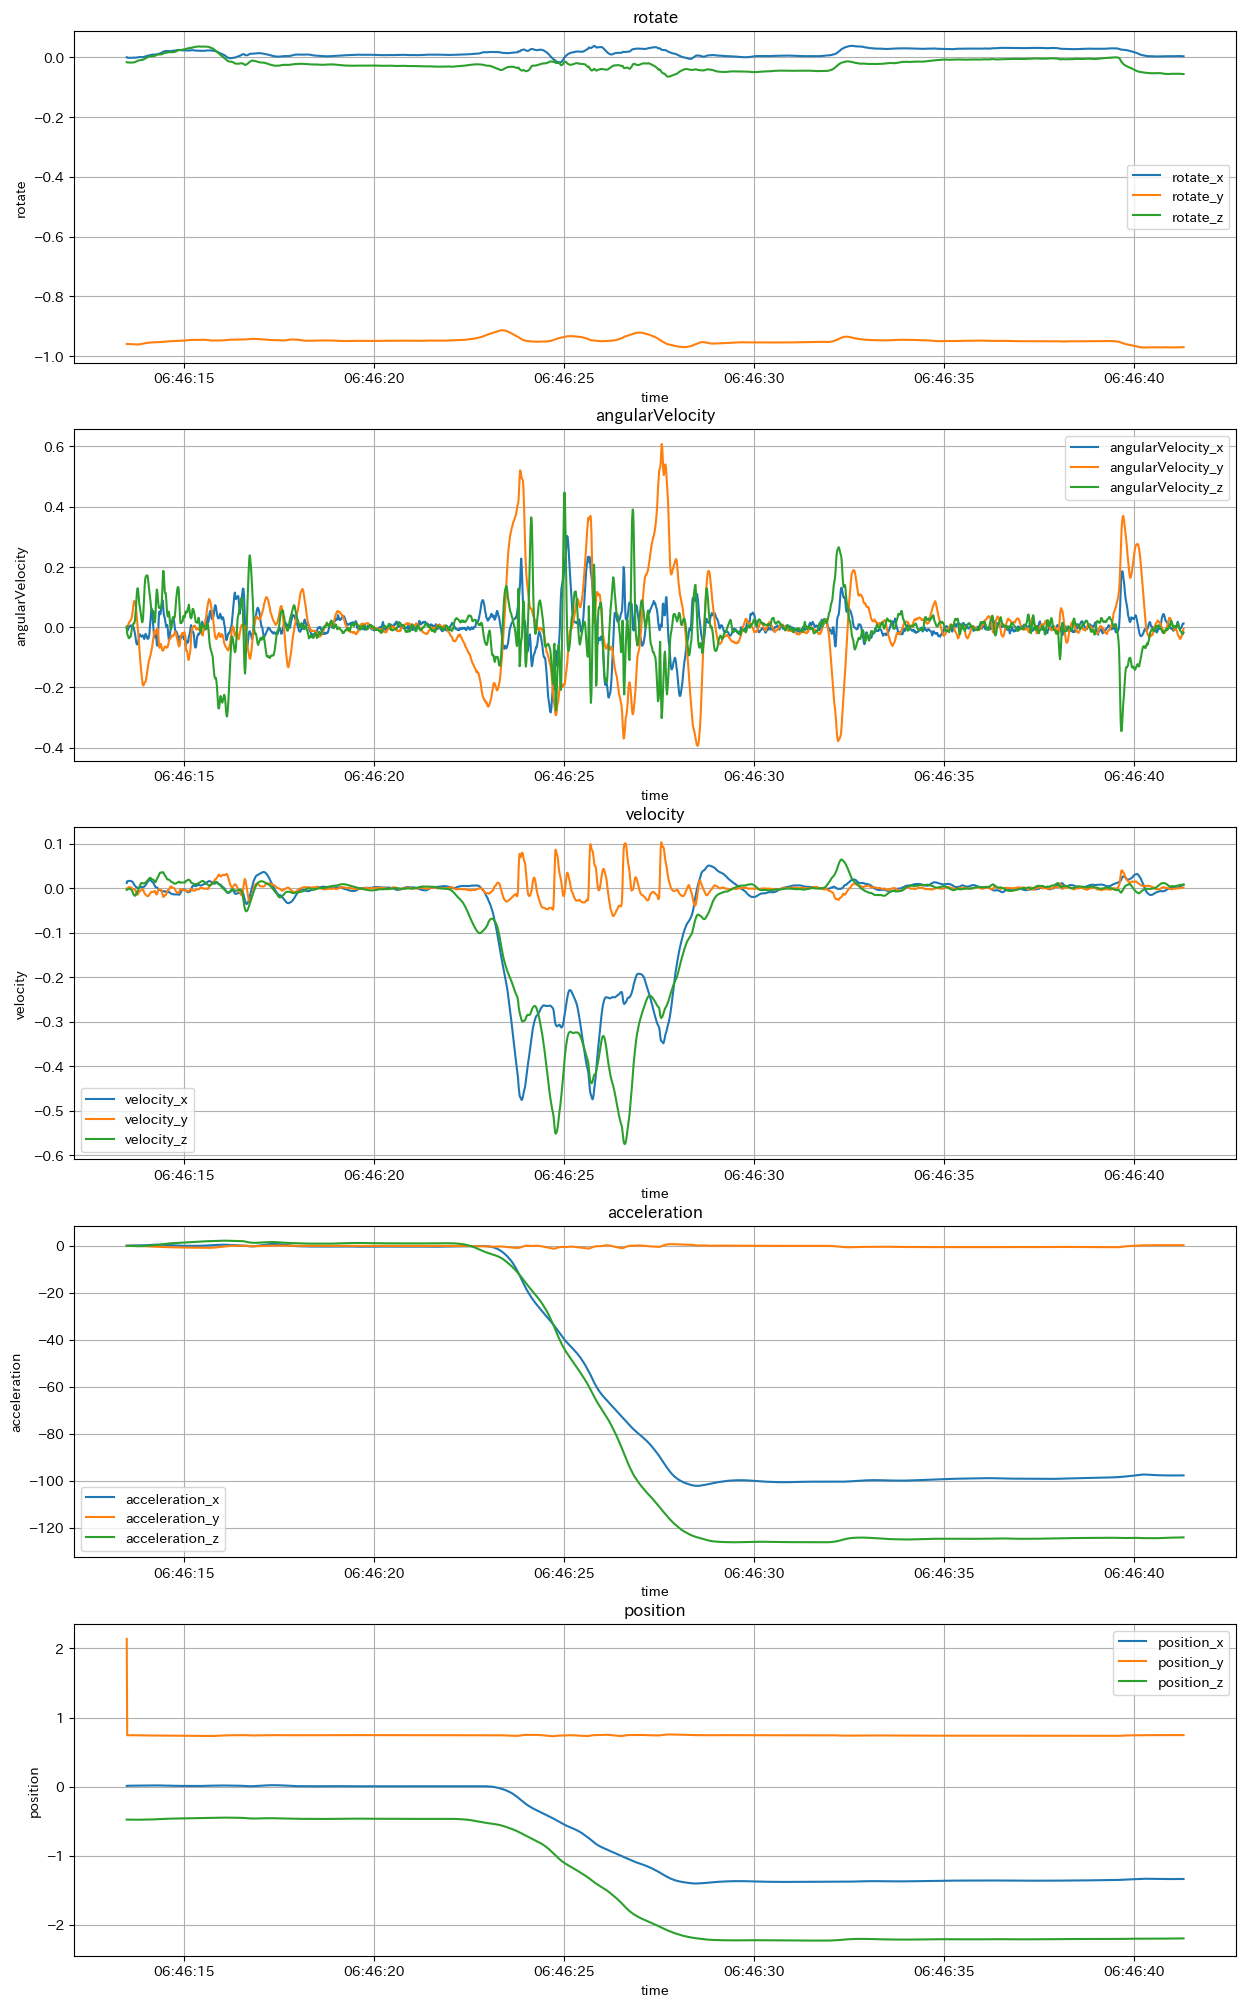

In [35]:
five_steps = Data('five_steps')
five_steps.plot('all', '', '')

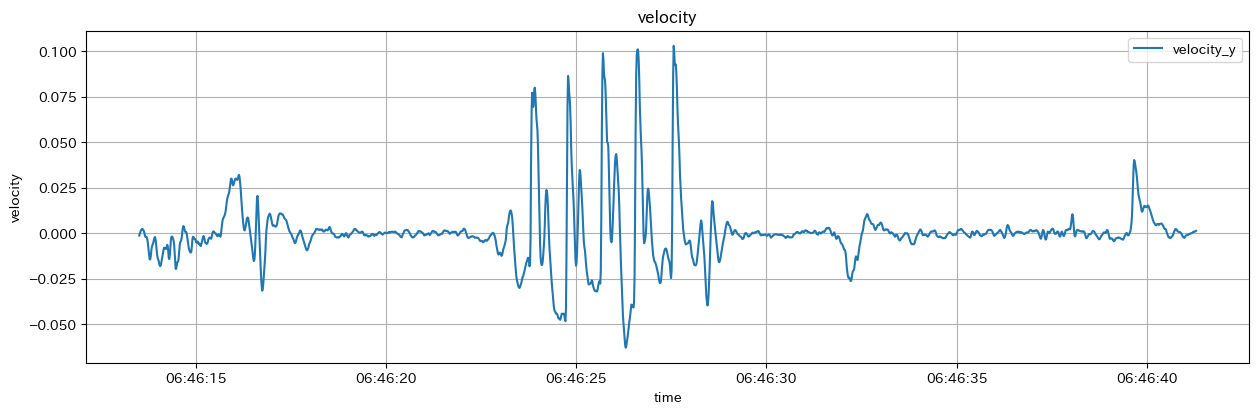

In [43]:
# low_filter
# five_steps.low_filter('velocity', filter_num*1)
five_steps.plot('velocity', '','y')

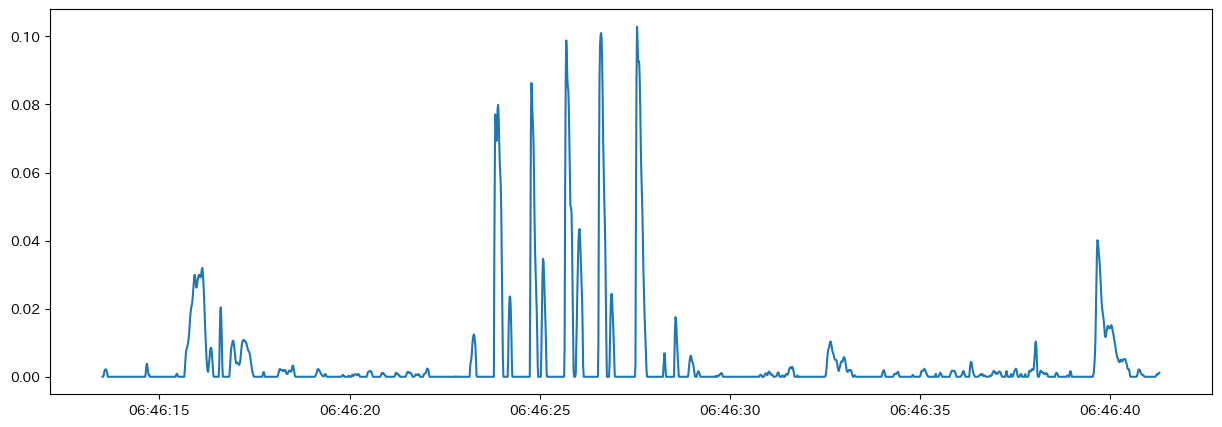

In [45]:
# 0以下を0にする
five_steps.df['velocity_y_pro'] = five_steps.df['velocity_y'].clip(lower=0)

# plot
fig = plt.figure(figsize=(15, 5))
plt.plot(five_steps.df['time'], five_steps.df['velocity_y_pro'], label = 'velocity_y_pro')
plt.show()

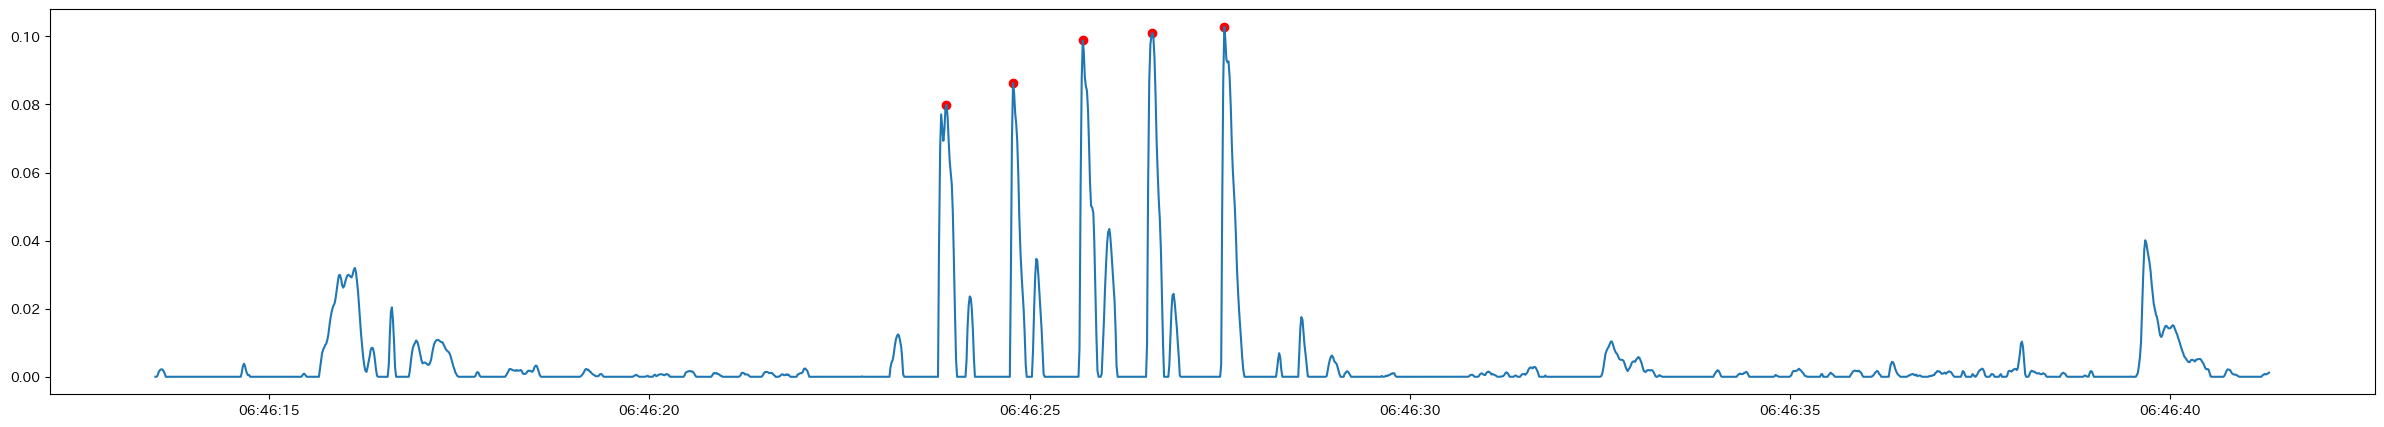

In [57]:
# peek
peek ,_ = find_peaks(five_steps.df['velocity_y_pro'], height=0.05, distance=20)

# plot
fig = plt.figure(figsize=(30, 5))
plt.plot(five_steps.df['time'], five_steps.df['velocity_y_pro'])
plt.scatter(five_steps.df['time'][peek], five_steps.df['velocity_y_pro'][peek], color='red')
plt.show()

In [25]:
# oculus_walkのデータを読み込む
oculus_walk = Data('oculus_walk')

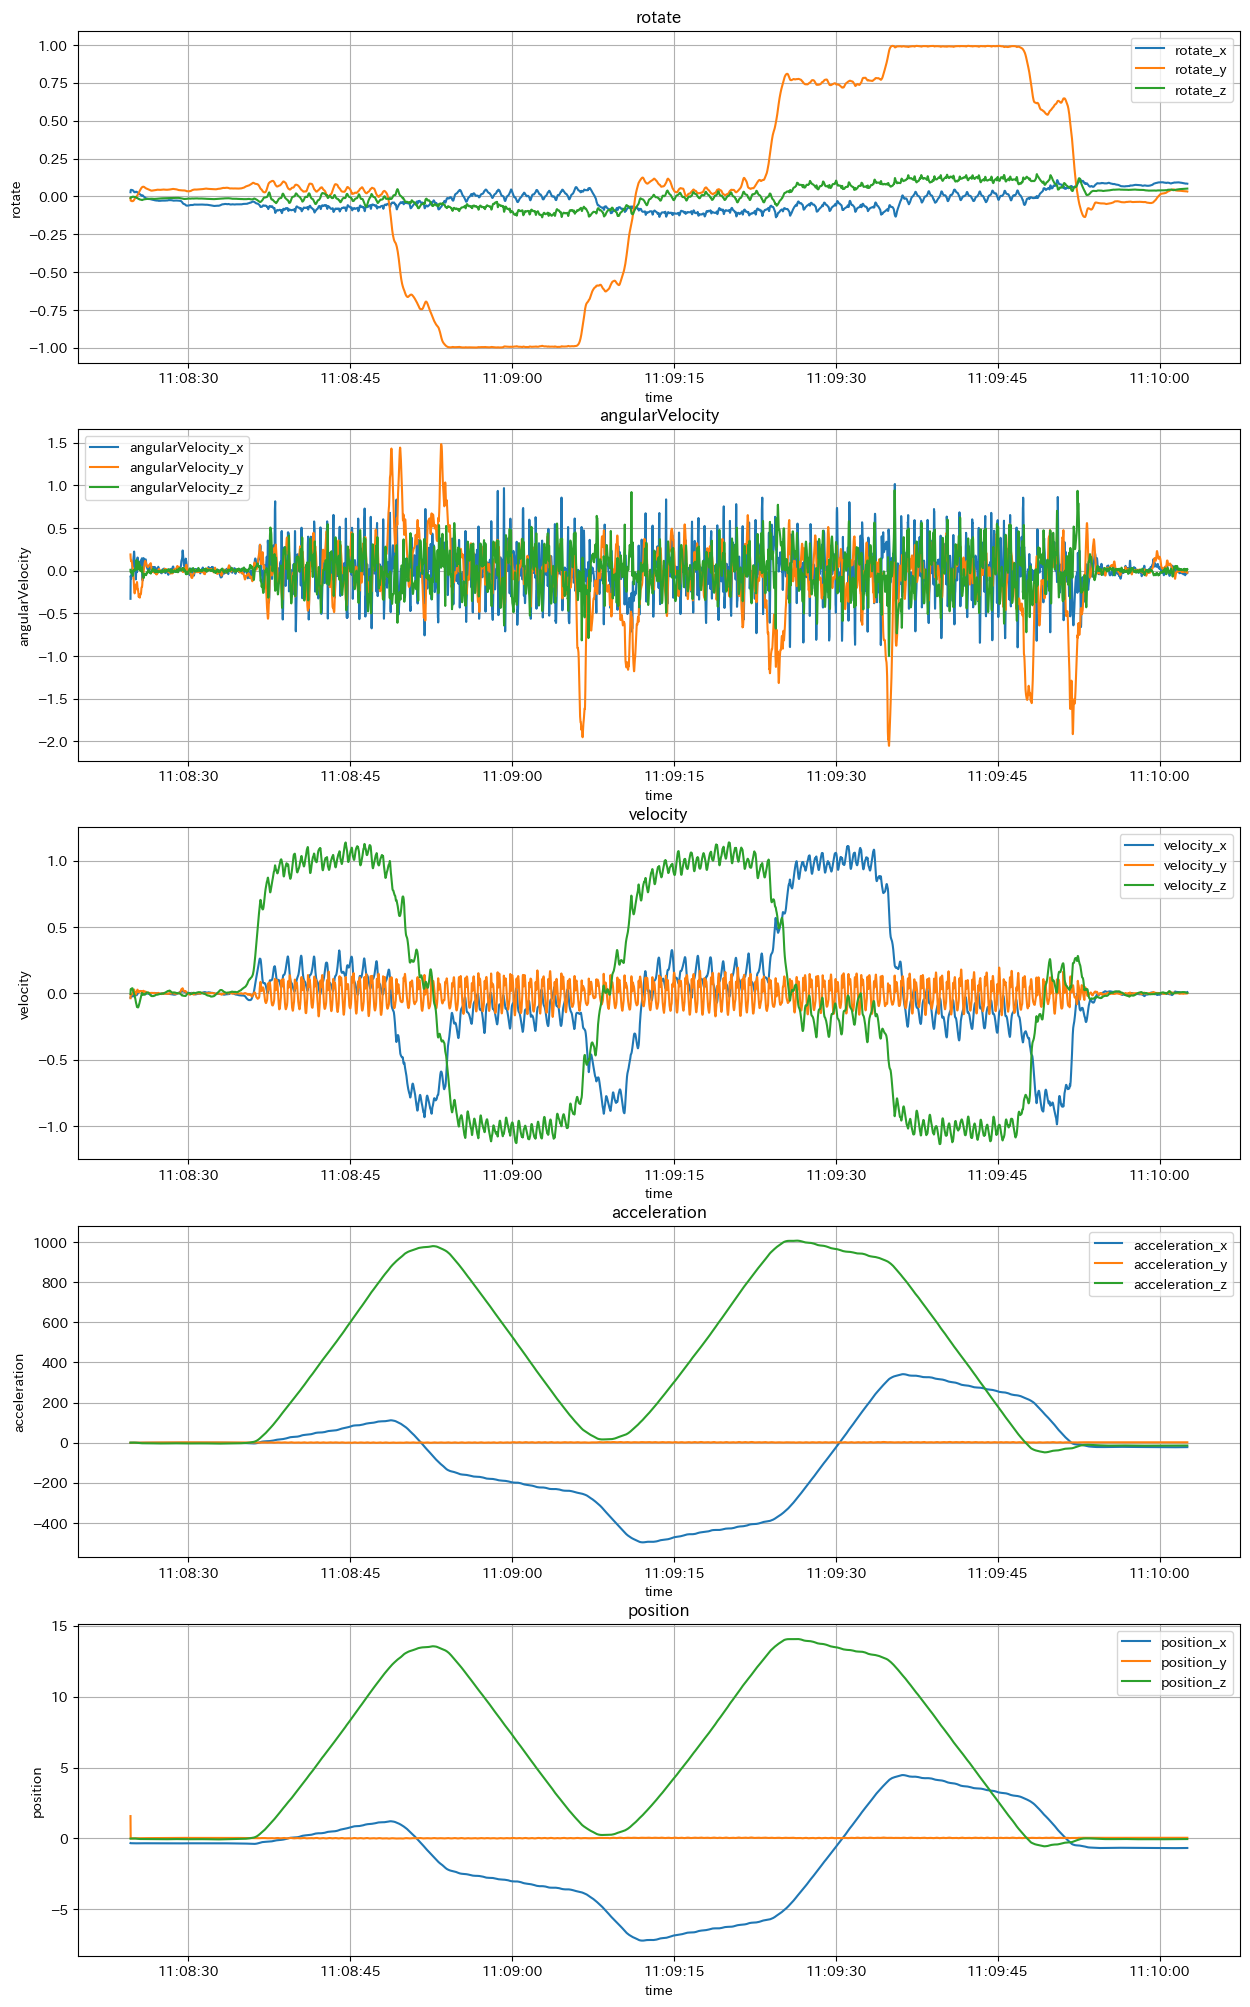

In [32]:
# all plot
oculus_walk.plot('all', '', '')

In [26]:
# # 時間を制限する
# start_time = '2023-10-31 11:08:30'
# end_time = '2023-10-31 11:10:00'
# # end_time = '2023-10-24 11:01:38'
# oculus_walk.split_time(start_time, end_time)

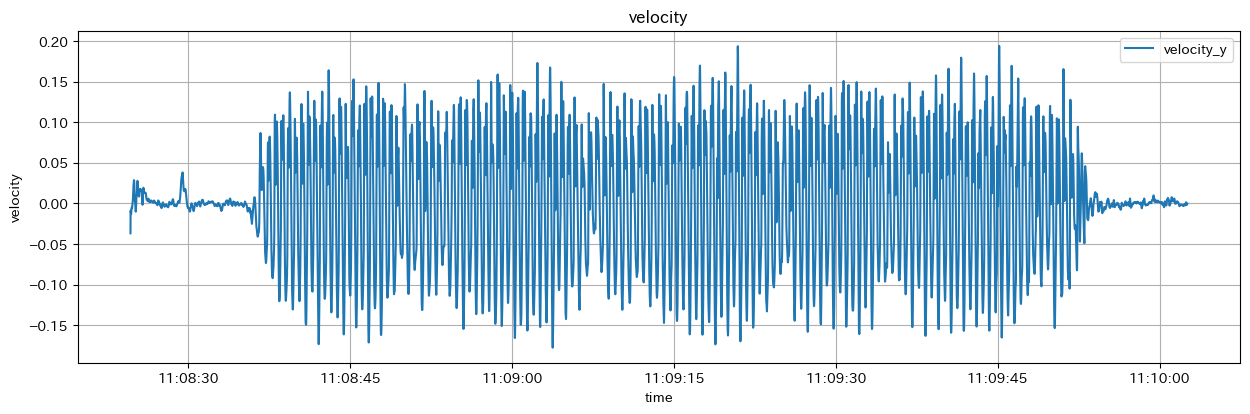

In [27]:
oculus_walk.plot('velocity', '','y')

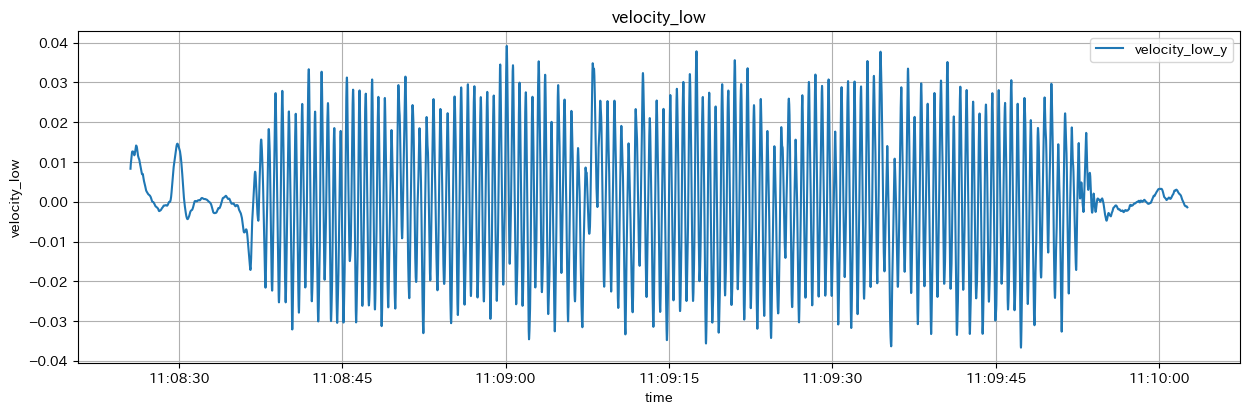

In [28]:
# low_filter
oculus_walk.low_filter('velocity', filter_num*10)
oculus_walk.plot('velocity', 'low','y')

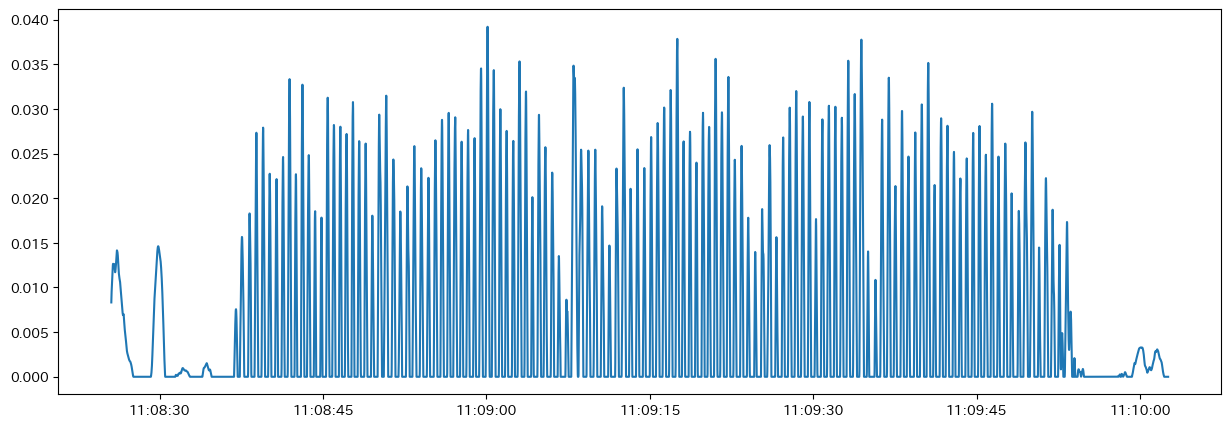

In [29]:
# 0以下を0にする
oculus_walk.df['velocity_low_y_pro'] = oculus_walk.df['velocity_low_y'].clip(lower=0)

# plot
fig = plt.figure(figsize=(15, 5))
plt.plot(oculus_walk.df['time'], oculus_walk.df['velocity_low_y_pro'], label = 'velocity_low_y_pro')
plt.show()

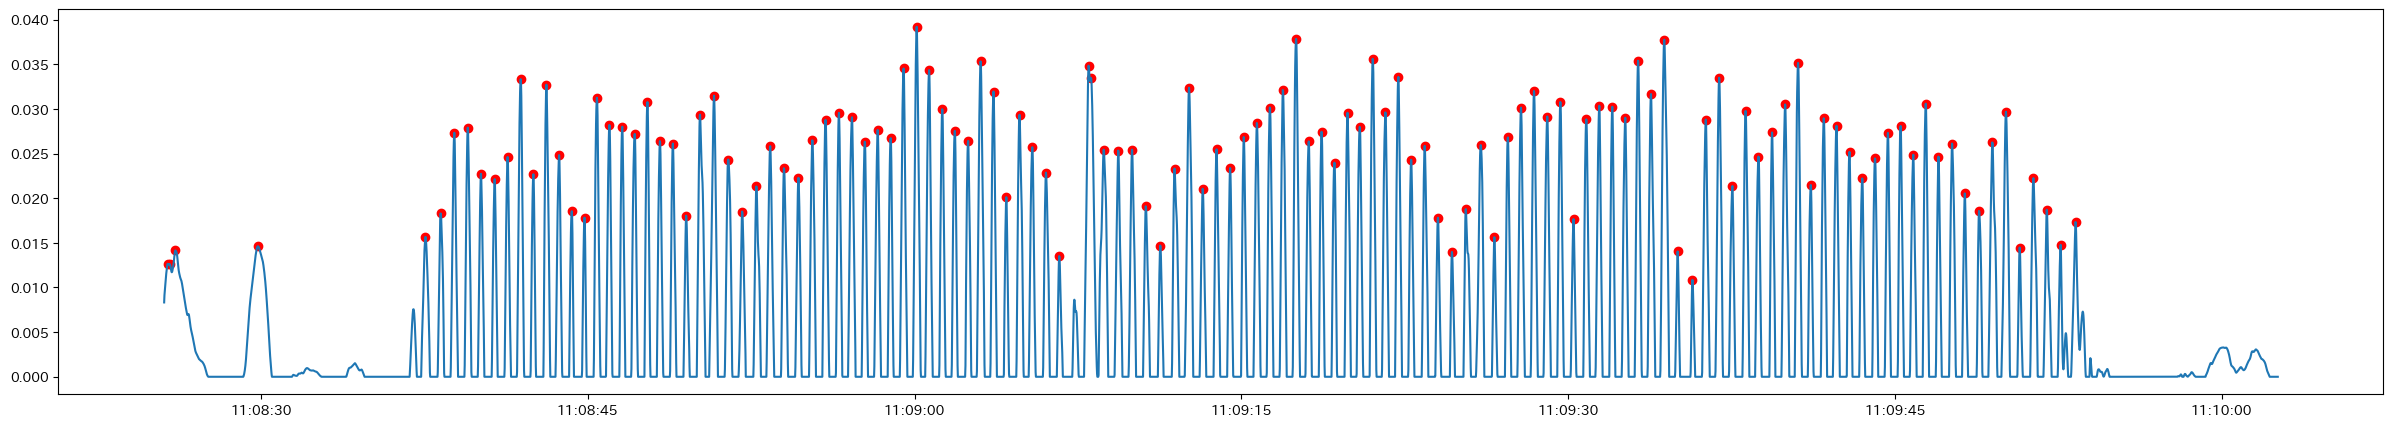

In [31]:
# peek
peek ,_ = find_peaks(oculus_walk.df['velocity_low_y_pro'], height=0.01, distance=6)

# plot
fig = plt.figure(figsize=(30, 5))
plt.plot(oculus_walk.df['time'], oculus_walk.df['velocity_low_y_pro'])
plt.scatter(oculus_walk.df['time'][peek], oculus_walk.df['velocity_low_y_pro'][peek], color='red')
plt.show()

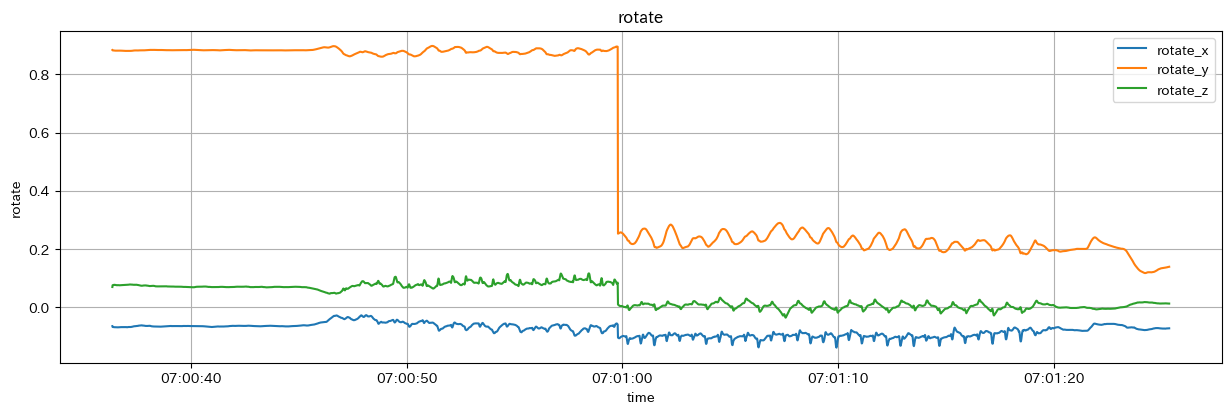

In [61]:
#
oculus_straight = Data('oculus_straight')
oculus_straight.plot('rotate', '', '')

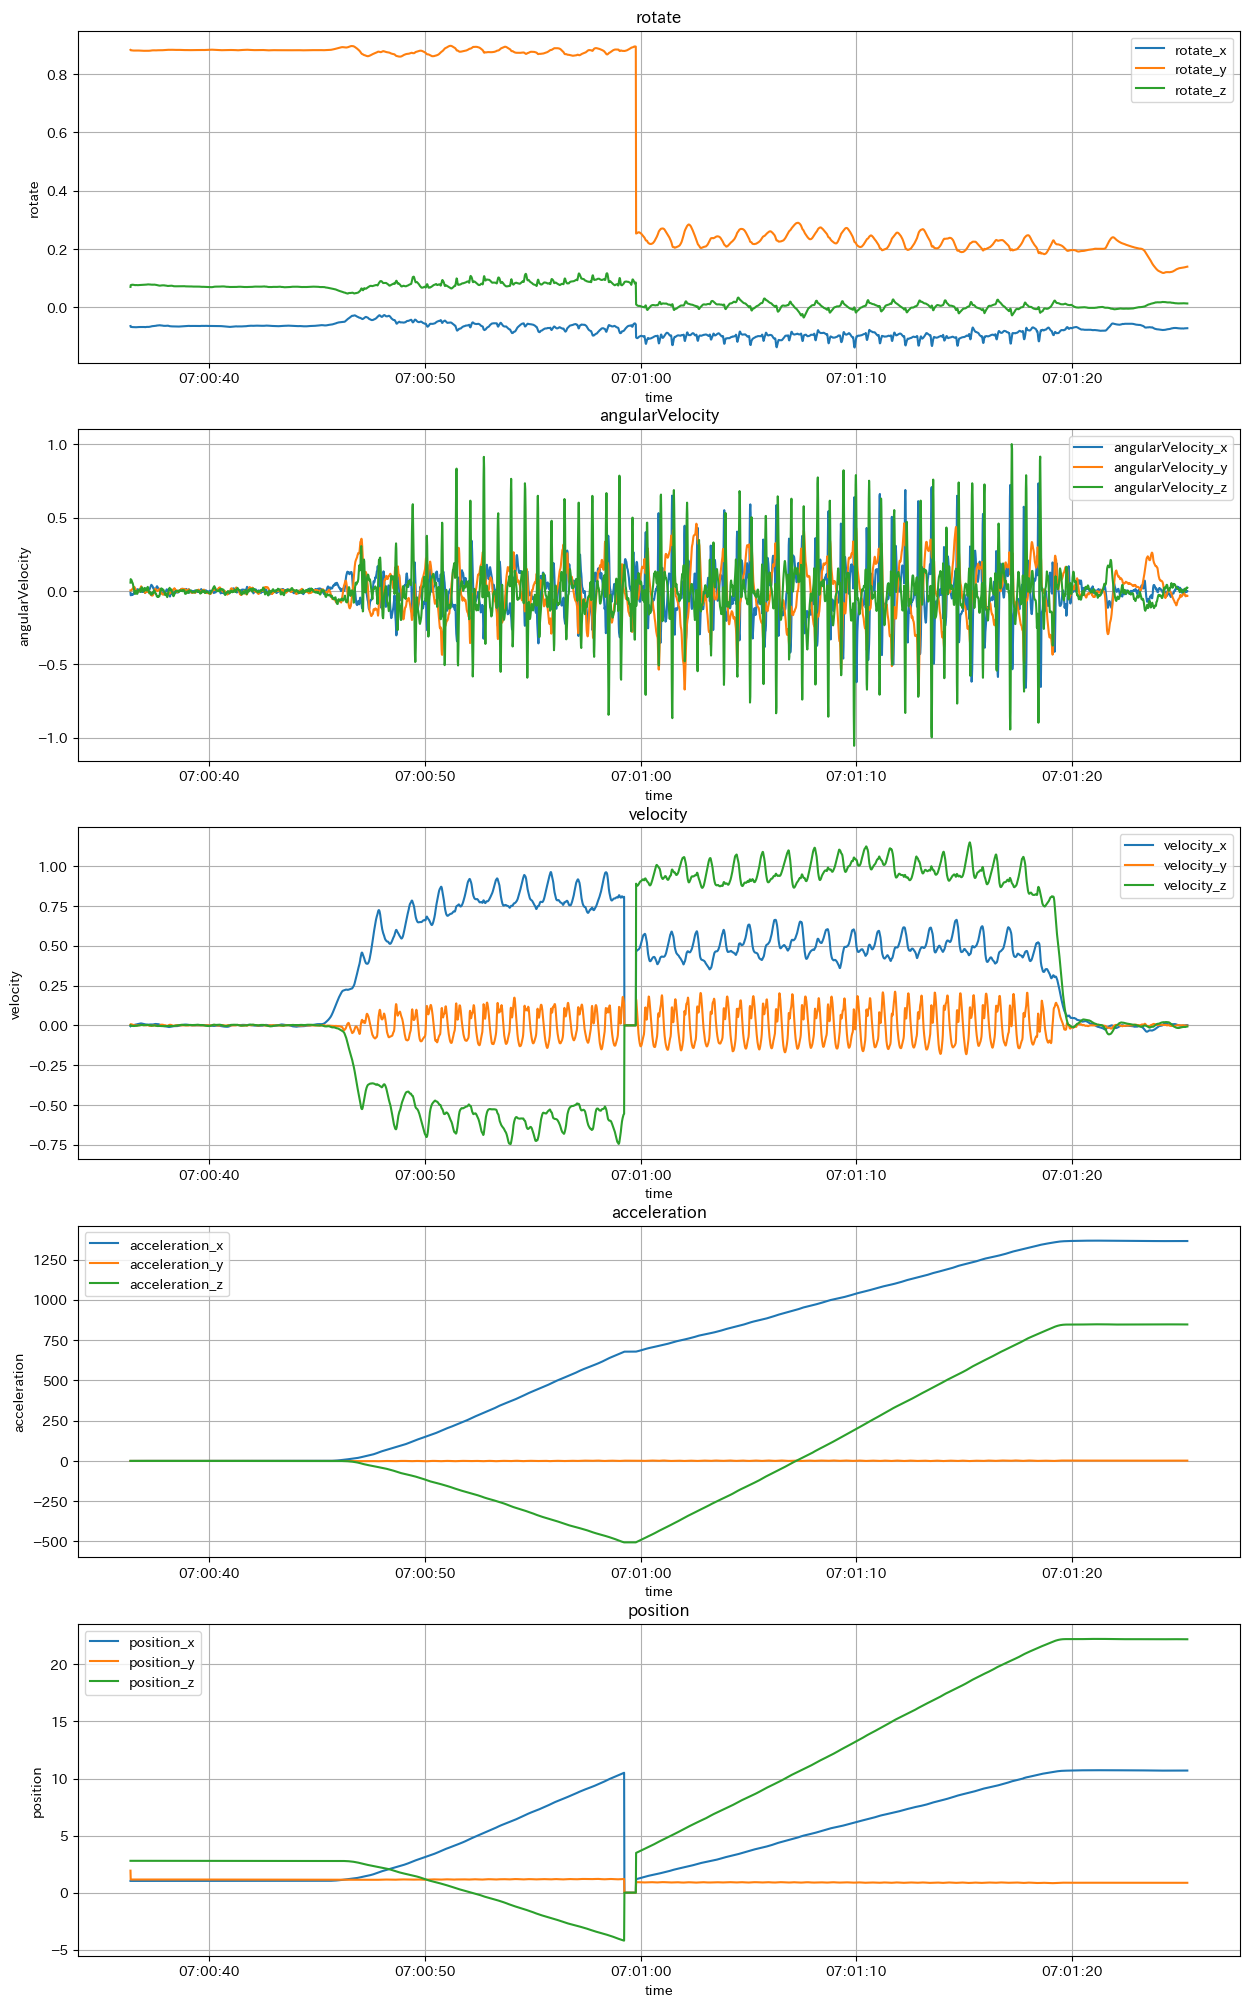

In [62]:
oculus_straight.plot('all', '', '')